In [1]:
% matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt

path = '/home/rbodo/.snntoolbox/data/imagenet/inception_averagepool/log/debug/v_clip'
debug_vars = np.load(os.path.join(path, 'debug_vars.npz'))
mem8 = debug_vars['mem8']
mem14 = debug_vars['mem14']
inputspiketimes8 = debug_vars['inputspikes8']
inputspiketimes14 = debug_vars['inputspikes14']
weights8 = debug_vars['weights8']
weights14 = debug_vars['weights14']
bias8 = debug_vars['bias8']  # first feature map
bias14 = debug_vars['bias14']  # 5th feature map
inputspikes8 = (inputspiketimes8 > 0).astype('int')
inputspikes14 = (inputspiketimes14 > 0).astype('int')
dt = 1
T = int(len(mem8) * dt)
t_clamp6 = 0 #10
t_clamp8 = 0 #20
t_clamp13 = 0#20
t_clamp14 = 0#30
v_clip = True

In [35]:
% matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt

path = '/home/rbodo/.snntoolbox/data/imagenet/inception_averagepool/log/debug/init_bias'
mem8 = np.load(os.path.join(path, 'mem8.npy'))
mem14 = np.load(os.path.join(path, 'mem14.npy'))
inputspiketimes8 = np.load(os.path.join(path, 'inputspikes8.npy'))
inputspiketimes14 = np.load(os.path.join(path, 'inputspikes14.npy'))
weights8 = np.load(os.path.join(path, 'weights8.npy'))
weights14 = np.load(os.path.join(path, 'weights14.npy'))
bias8 = 0.23438094183802605
bias14 = 0.51390331238508224
inputspikes8 = (inputspiketimes8 > 0).astype('int')
inputspikes14 = (inputspiketimes14 > 0).astype('int')
dt = 1
T = int(len(mem8) * dt)
t_clamp6 = 0 #10
t_clamp8 = 0 #20
t_clamp13 = 0#20
t_clamp14 = 0#30

In [2]:
path_to_activations = '/home/rbodo/.snntoolbox/data/imagenet/inception_averagepool/log/normalization/activations'
activations_batch8 = np.load(os.path.join(path_to_activations, '08Convolution2D_48x35x35.npz'))['arr_0']
activations_batch14 = np.load(os.path.join(path_to_activations, '14Convolution2D_32x35x35.npz'))['arr_0']
activation8 = activations_batch8[0, 0, 0, 0] / 7.1  # Apply normalization
activation14 = activations_batch14[0, 4, 0, 34] / 4.43  # Apply normalization

In [3]:
def get_input_voltage(spikes, weights, bias):
    return np.dot(spikes, weights) + bias

In [4]:
input8 = get_input_voltage(inputspikes8, weights8, bias8)
input14 = get_input_voltage(inputspikes14, weights14, bias14)

In [5]:
def get_membrane_potential(input_t, reset, t_clamp=0):
    v = 0
    v_t = [0] * t_clamp
    spikes_t = []
    for t in range(len(input_t)):
        if t < t_clamp:
            continue
        v += input_t[t]
        if v_clip:
            v = np.clip(v, -2, 2)
        if v >= 1:
            if reset == 'sub':
                v -= 1
            elif reset == 'zero':
                v = 0
            elif reset == 'mod':
                v %= 1
            spikes_t.append(t)
        v_t.append(v)
    return np.array(v_t), spikes_t

In [6]:
reset = 'sub'
mmem8, spikes8 = get_membrane_potential(input8, reset, t_clamp8)
mmem14, spikes14 = get_membrane_potential(input14, reset, t_clamp14)

In [7]:
mem_list = [mem8, mem14]
mmem_list = [mmem8, mmem14]
results = []
for mem, mmem in zip(mem_list, mmem_list):
    results.append(np.isclose(mem - mmem, np.zeros_like(mem), atol=1e-4))
print(np.all(results))

True


In [8]:
def plot_spiketrains(spiketimes_layers, labels):
    num_layers = len(spiketimes_layers)
    f, ax = plt.subplots(num_layers, 1, sharex=True, sharey=True)
    f.set_figwidth(10)
    f.set_figheight(10 * num_layers)
    ax[-1].set_xlabel('t')
    for i, spiketimes in enumerate(spiketimes_layers):
        ax[i].set_title(labels[i])
        ax[i].set_ylabel('neuron index')
        for (neuron, spiketrain) in enumerate(spiketimes.transpose()):
            spikelist = [j for j in spiketrain if j != 0]
            y = np.ones_like(spikelist) * neuron
            ax[i].plot(spikelist, y, '.')
    f.savefig(os.path.join(path, 'input_spiketrains'))

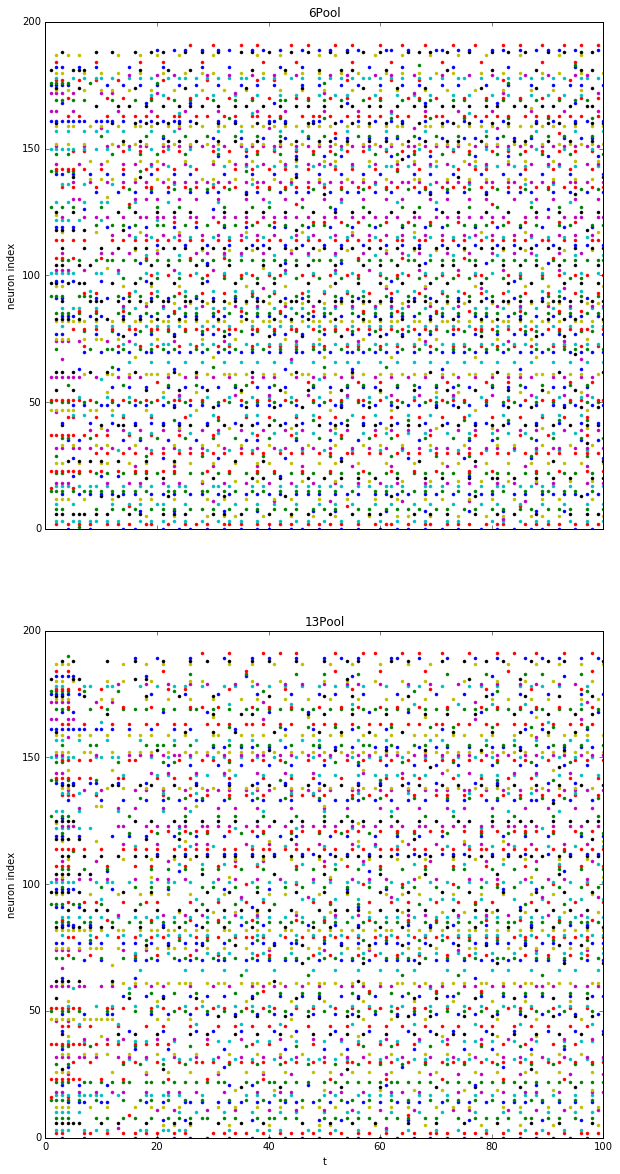

In [10]:
plot_spiketrains([inputspiketimes8, inputspiketimes14], ['6Pool', '13Pool'])

In [11]:
def get_rates(spiketimes, t_clamp=0, idx=0):
    rates = [0] * t_clamp
    count = 0
    t_idx = int(np.ceil(t_clamp/dt))
    for t in np.arange(t_clamp, T, dt):
        count += int(spiketimes.transpose()[idx][t_idx] > 0)
        rates.append(count/(t+dt-t_clamp))
        t_idx += 1
    return rates


def plot_spikerates(spiketimes_layers, labels, target_activations=None, t_clamp=None, idx=0, filename='spikerates'):
    plt.title('Spike-rates')
    plt.xlabel('t')
    plt.ylabel('spike-rate')
    colors = ['blue', 'green']  # plt.cm.plasma(np.linspace(0, 0.9, len(labels)))
    if t_clamp is None:
        t_clamp = len(spiketimes_layers) * [0]
    for i, spiketimes in enumerate(spiketimes_layers):
        plt.plot(np.arange(0, T, dt), get_rates(spiketimes, t_clamp[i], idx), label=labels[i], color=colors[i])
        if target_activations:
            plt.plot([0, T], [target_activations[i], target_activations[i]], label='{}_target'.format(labels[i]), color=colors[i])
    plt.legend(loc='center right')
    plt.savefig(os.path.join(path, filename))

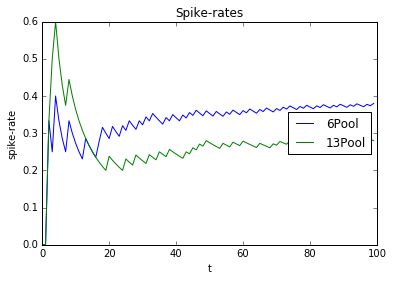

In [12]:
t_clamp = [t_clamp6, t_clamp13]
plot_spikerates([inputspiketimes8, inputspiketimes14], ['6Pool', '13Pool'], t_clamp=t_clamp, idx=135, filename='spikerates_in')

In [13]:
def plot_cumsum(input_t, labels):
    plt.title('Cumulated input')
    plt.xlabel('t')
    plt.ylabel('V')
    for i, inp in enumerate(input_t):
        plt.plot(np.arange(0, T, dt), np.cumsum(inp), label=labels[i])
    plt.legend()
    plt.savefig(os.path.join(path, 'cum_input'))

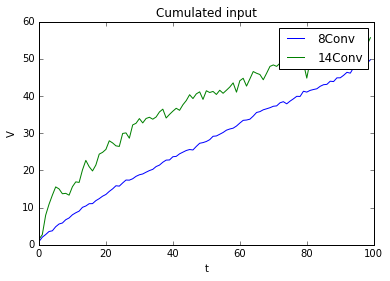

In [14]:
plot_cumsum([input8, input14], ['8Conv', '14Conv'])

In [15]:
def plot_input_t(input_t, labels):
    plt.title('Input vs time')
    plt.xlabel('t')
    plt.ylabel('V')
    for i, inp in enumerate(input_t):
        plt.plot(np.arange(0, T, dt), inp, label=labels[i])
    plt.legend()
    plt.savefig(os.path.join(path, 'input_t'))

In [16]:
input_list = [input8, input14]
num_spikes_list = [len(spikes8), len(spikes14)]
mem_list = [mem8[-1], mem14[-1]]
clamp_list = [t_clamp8, t_clamp14]
results = []
for inp, num_spikes, mem, t_clamp in zip(input_list, num_spikes_list, mem_list, clamp_list):
    results.append(np.isclose(np.sum(inp[t_clamp:]) - num_spikes - mem, 0, atol=1e-5))
print(all(results))

False


In [17]:
def plot_vmem(mem_layers, spikes_layers, labels, title='V_mem'):
    num_layers = len(mem_layers)
    f, ax = plt.subplots(num_layers, 1, sharex=True, sharey=True)
    f.set_figheight(4 * num_layers)
    f.set_figwidth(10)
    ax[-1].set_xlabel('t')
    for i in range(num_layers):
        ax[i].plot(np.arange(0, T, dt), mem_layers[i], label='V_mem')
        ax[i].plot([s * dt for s in spikes_layers[i]], np.ones_like(spikes_layers[i]), '.', label='spikes')
        ax[i].set_title(labels[i])
        ax[i].set_ylabel('V')
        ax[i].legend()
    f.savefig(os.path.join(path, title))

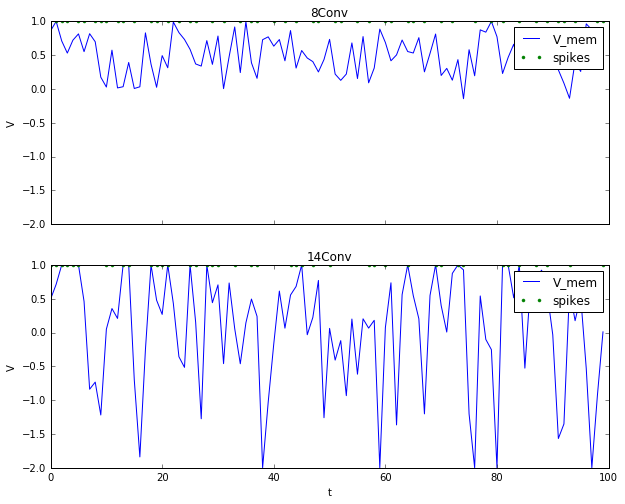

In [18]:
plot_vmem([mem8, mem14], [spikes8, spikes14], ['8Conv', '14Conv'])

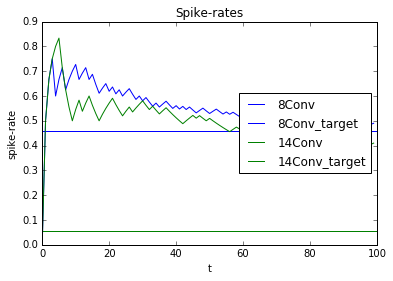

In [19]:
spiketimes8 = np.zeros((int(T/dt), 1))
spiketimes8[spikes8, 0] = spikes8
spiketimes14 = np.zeros((int(T/dt), 1))
spiketimes14[spikes14, 0] = spikes14
t_clamp = [t_clamp8, t_clamp14]
plot_spikerates([spiketimes8, spiketimes14], ['8Conv', '14Conv'], [activation8, activation14], t_clamp=t_clamp, filename='spikerates_out')